In [10]:
import psycopg2
import matplotlib.pyplot as plt 
import csv
import pandas as pd
import numpy as np

### 1. Extracting data from the PostgreSQL database

In [2]:
def export_to_csv(sql_command, filename, user, dbname):
    conn = psycopg2.connect(
        user=user,
        dbname=dbname
    )
    cursor = conn.cursor()
    cursor.execute(sql_command)
    rows = cursor.fetchall()
    with open(filename, "w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([desc[0] for desc in cursor.description])
        csv_writer.writerows(rows)
    cursor.close()
    conn.close()

In [3]:
select_data_sql_1 = """
SELECT
    words.id AS word_id,
    words.body AS word_body,
    translations.id AS translation_id,
    translations.body AS translation_body,
    translations.rating,
    translations.created_at AS translation_created_at,
    words.translations_count
FROM
    words
LEFT JOIN
    translations ON words.id = translations.word_id
ORDER BY
    words.id ASC,
    translations.created_at ASC;
"""


select_data_sql_2 = """
SELECT * FROM votes;
"""

In [4]:
export_to_csv(select_data_sql_1, "../data/words_translations.csv", "alexeykoshevoy", "slovotvir")

In [5]:
export_to_csv(select_data_sql_2, "../data/votes.csv", "alexeykoshevoy", "slovotvir")

### 2. Preparing the data for analysis

In [6]:
votes = pd.read_csv("../data/votes.csv")
votes['created_at'] = pd.to_datetime(votes['created_at'])
votes['created_at_year'] = votes['created_at'].dt.year

In [7]:
df = pd.read_csv('../data/words_translations.csv')
df = df.dropna(subset=['rating'])
df['rating'] = df['rating'].astype(int)
# only keep rows where rating is not 0
df = df[df['rating'] != 0]
# subtract mean and divide by std per word
df['rating_n'] = df.groupby('word_id')['rating'].transform(lambda x: (x - x.mean()) / x.std())
df['translation_created_at'] =  pd.to_datetime(df['translation_created_at'])
df['translation_created_at_year'] = df['translation_created_at'].dt.year

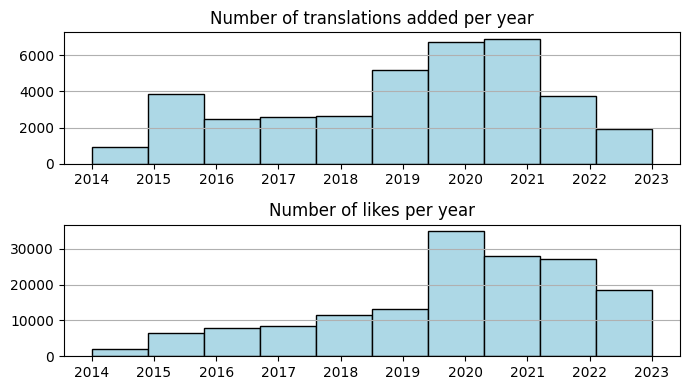

In [11]:
# plot translations per year and likes per year on the same plot as two subplots organized in 2 rows and 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 4))
df['translation_created_at_year'].hist(ax=axes[0], histtype='bar', ec='black', color='lightblue', grid=False, align='mid')
# add grid lines only horizontally
axes[0].grid(axis='y')
axes[0].set_title('Number of translations added per year')
# add x ticks for each year
axes[0].set_xticks(np.arange(df['translation_created_at_year'].min(), df['translation_created_at_year'].max()+1, 1.0))
votes['created_at_year'].hist(ax=axes[1], histtype='bar', ec='black', color='lightblue', grid=False, align='mid')
axes[1].grid(axis='y')
axes[1].set_title('Number of likes per year')
# add x ticks for each year
axes[1].set_xticks(np.arange(votes['created_at_year'].min(), votes['created_at_year'].max()+1, 1.0))
plt.tight_layout()
plt.show()